<a href="https://www.kaggle.com/code/shahdmohamedkamel/cnn-for-histopathology-accuracy-96?scriptVersionId=148104318" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aaaaaa/DenseNet-BC-121-32-no-top.h5
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca637.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca3400.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca783.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca3927.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca4109.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca95.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca488.jpeg
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_i

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_26/1202922517.py:24: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
colon_dir=r'../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets'
lung_dir=r'../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
for i,d in enumerate([colon_dir,lung_dir]):
    filepaths=[]
    labels=[]
    classlist=os.listdir(d)
    for klass in classlist:
        classpath=os.path.join(d,klass)
        if os.path.isdir(classpath):
            flist=os.listdir(classpath)
            for f in flist:
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)                   
    Fseries= pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    if i==0:
        colon_df=pd.concat([Fseries, Lseries], axis=1)
    else:
        lung_df=pd.concat([Fseries, Lseries], axis=1)
df=pd.concat([colon_df, lung_df], axis =0).reset_index(drop=True)# make a combined dataframe
print (df.head())
print(df['labels'].value_counts())

                                           filepaths     labels
0  ../input/lung-and-colon-cancer-histopathologic...  colon_aca
1  ../input/lung-and-colon-cancer-histopathologic...  colon_aca
2  ../input/lung-and-colon-cancer-histopathologic...  colon_aca
3  ../input/lung-and-colon-cancer-histopathologic...  colon_aca
4  ../input/lung-and-colon-cancer-histopathologic...  colon_aca
labels
colon_aca    5000
colon_n      5000
lung_aca     5000
lung_scc     5000
lung_n       5000
Name: count, dtype: int64


In [4]:
df.shape

(25000, 2)

In [5]:
sample_size=5000
sample_list=[]
group=df.groupby('labels')
for label in df['labels'].unique():    
    label_group=group.get_group(label).sample(sample_size, replace=True, random_state=123, axis=0)    
    sample_list.append(label_group)
df=pd.concat(sample_list, axis=0).reset_index(drop=True)
print (len(df))

25000


In [6]:
train_split=0.75* sample_size
test_split=0.25 *sample_size
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=0.75, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), ' _test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  18750  _test_df length:  3125   valid_df length:  3125


In [7]:
from PIL import Image

# Open the image file
image = Image.open("/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca1.jpeg")  # Replace "image.jpg" with the path to your image file
w,h = image.size 
# Resize the image
new_size = (300, 300)  # Specify the desired width and height for the resized image
resized_image = image.resize(new_size)
print (w,h)
# Save the resized image
#resized_image.save("resized_image.jpg")  # Replace "resized_image.jpg" with the desired output file path

768 768


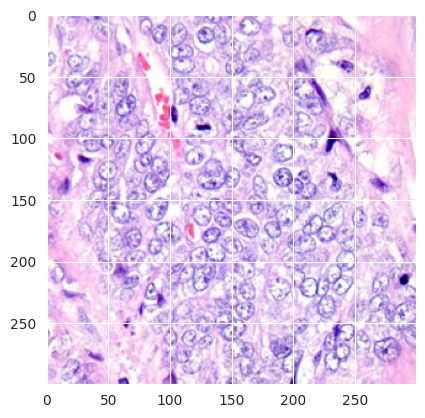

In [8]:
plt.imshow(resized_image)
#plt.axis('off')  # Remove the axes and ticks
plt.show()

In [9]:
gen=ImageDataGenerator()
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=(128,128), class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=123)

test_gen=gen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=(128,128), class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=123)

valid_gen=gen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=(128,128), class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=123)

classes=list(train_gen.class_indices.keys())
class_count=len(classes)

Found 18750 validated image filenames belonging to 5 classes.
Found 3125 validated image filenames belonging to 5 classes.
Found 3125 validated image filenames belonging to 5 classes.


In [10]:
def show_image_samples(gen , train_df ):
    test_dict=gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        #image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(images[i]/255)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()
    sns.countplot(train_df, x='labels')


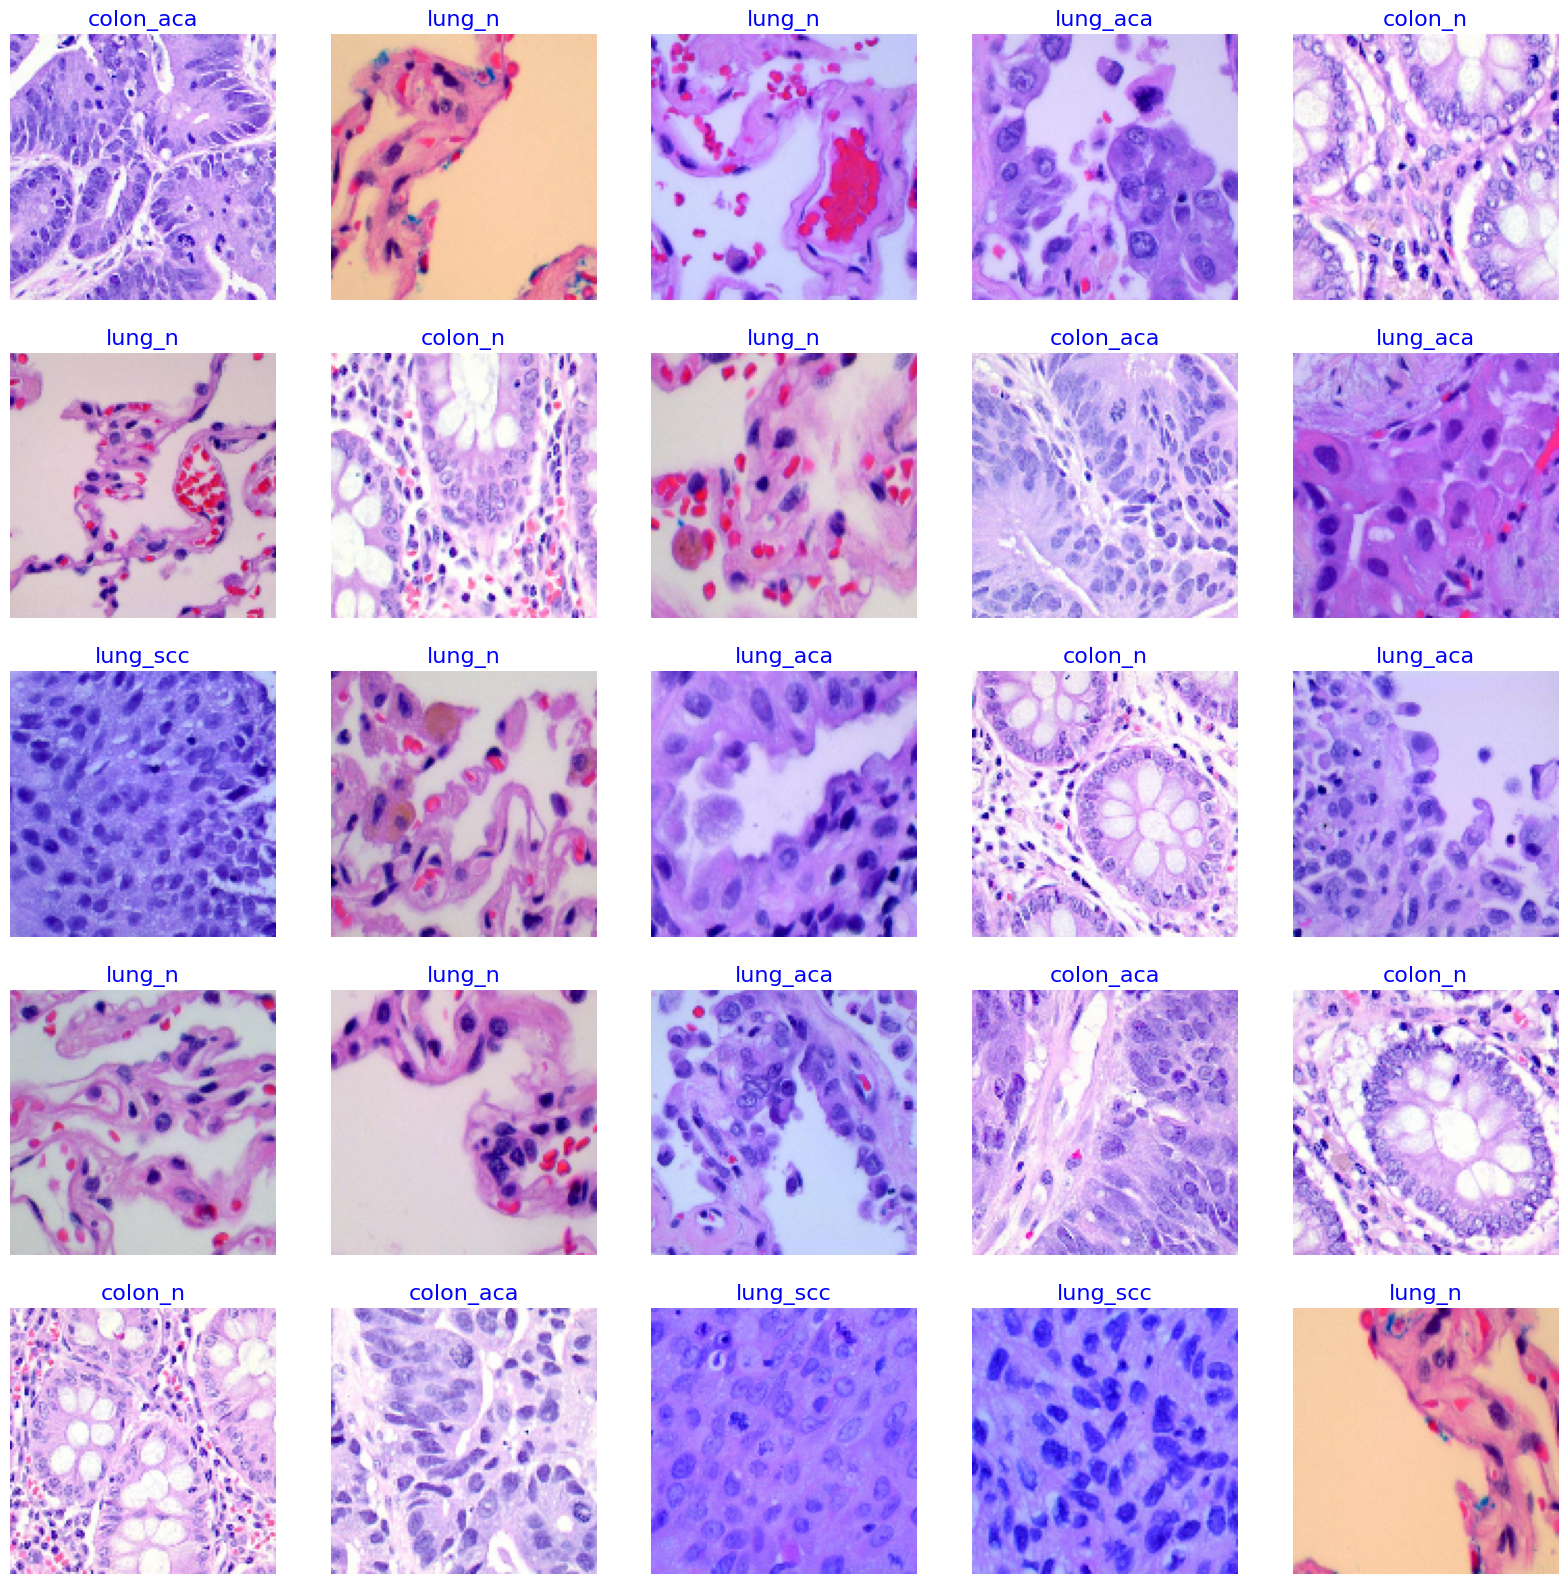

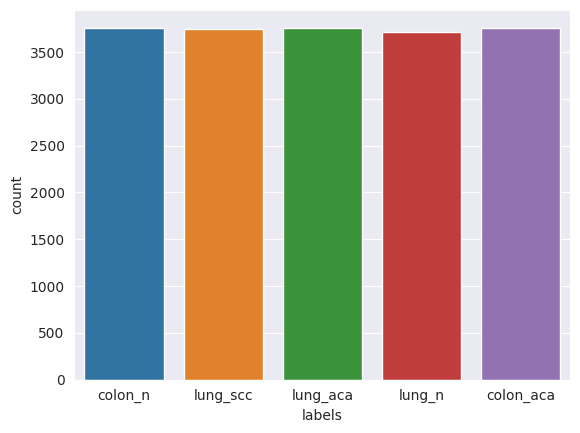

In [11]:
show_image_samples(train_gen, train_df)

In [12]:
from keras import layers,models

In [13]:
model = models.Sequential([
      layers.Conv2D(64, (4,4),padding="same", activation='relu', input_shape=(128, 128, 3)),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64, (4,4), activation='sigmoid'),
      layers.Conv2D(64, (3,3), activation='relu'),
      layers.Conv2D(64, (3,3), activation='relu' ),
      layers.Conv2D(32, (3,3), activation='relu' ),
      layers.Conv2D(32, (3,3), activation='relu' ),
    # Flatten the results to feed into a DNN
      layers.Flatten(),
      # 512 neuron hidden layer
        layers.Dropout(0.1),
      layers.Dense(512, activation='relu'),
        layers.Dropout(0.1),
      layers.Dense(5, activation='sigmoid')
    ])
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
"""model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])
"""



'model = Sequential([\n    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),\n    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),\n    MaxPooling2D((2, 2)),\n    \n    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),\n    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),\n    MaxPooling2D((2, 2)),\n    \n    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),\n    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),\n    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),\n    MaxPooling2D((2, 2)),\n    \n    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),\n    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),\n    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),\n    MaxPooling2D((2, 2)),\n    \n    Conv2D(filters=512,

In [14]:
history = model.fit(train_gen, epochs=10, verbose=1,validation_data=(valid_gen))

Epoch 1/10
153/153 [==============================] - 193s 1s/step - loss: 14.7154 - accuracy: 0.2010 - val_loss: 27.3583 - val_accuracy: 0.1894
Epoch 2/10
153/153 [==============================] - 81s 531ms/step - loss: 8.3903 - accuracy: 0.2003 - val_loss: 1.7161 - val_accuracy: 0.1894
Epoch 3/10
153/153 [==============================] - 78s 510ms/step - loss: 1.6340 - accuracy: 0.2002 - val_loss: 1.8658 - val_accuracy: 0.1907
Epoch 4/10
153/153 [==============================] - 81s 526ms/step - loss: 4.7762 - accuracy: 0.2006 - val_loss: 2.0006 - val_accuracy: 0.1898
Epoch 5/10
153/153 [==============================] - 81s 527ms/step - loss: 1.7910 - accuracy: 0.2001 - val_loss: 1.6097 - val_accuracy: 0.1894
Epoch 6/10
153/153 [==============================] - 79s 516ms/step - loss: 1.6095 - accuracy: 0.2005 - val_loss: 1.6096 - val_accuracy: 0.1894
Epoch 7/10
153/153 [==============================] - 81s 529ms/step - loss: 1.6095 - accuracy: 0.1980 - val_loss: 1.6096 - val_ac

In [15]:
Model_trial = pd.DataFrame(model.history.history)
Model_trial.head()

loss  accuracy   val_loss  val_accuracy
0  14.715433  0.201013  27.358313       0.18944
1   8.390318  0.200320   1.716140       0.18944
2   1.634001  0.200160   1.865752       0.19072
3   4.776188  0.200587   2.000590       0.18976
4   1.790974  0.200107   1.609715       0.18944

<Axes: >

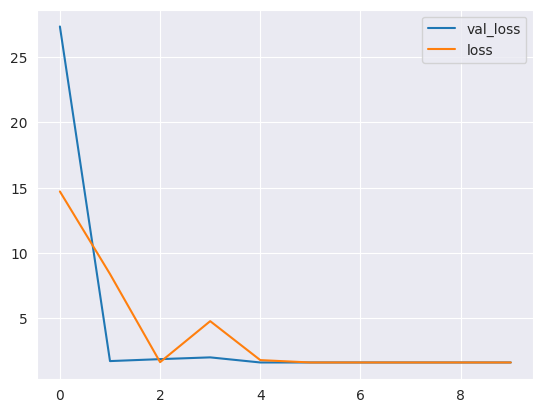

In [16]:
Model_trial[["val_loss","loss"]].plot()

<Axes: >

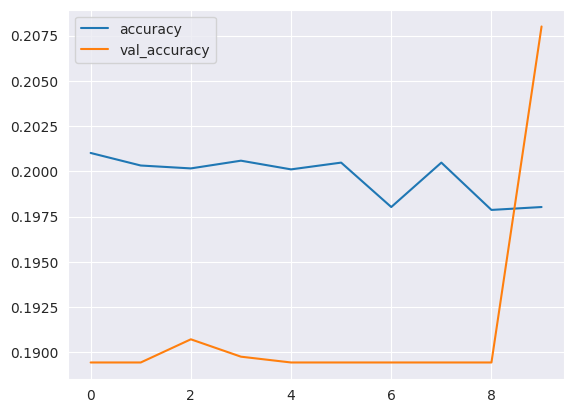

In [17]:
Model_trial[["accuracy","val_accuracy"]].plot()

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      3136      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        65600     
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 57, 57, 64)        36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 55, 55, 32)        18464     
                                                        

In [19]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

125/125 [==============================] - 20s 155ms/step - loss: 1.6095 - accuracy: 0.1888
Train Loss:  1.6094293594360352
Train Accuracy:  0.1999349594116211
--------------------
Validation Loss:  1.6095343828201294
Validation Accuracy:  0.20800000429153442
--------------------
Test Loss:  1.6095120906829834
Test Accuracy:  0.18880000710487366


In [20]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

/tmp/ipykernel_26/2668681149.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


[0 0 0 ... 0 0 0]


In [21]:
from tensorflow.keras.models import save_model

In [22]:
save_model(model, '/kaggle/working/model.h5')

In [23]:
"""#with a .pt  extension
import torch


torch.save(model.state_dict(), "my_model.pt")"""

'#with a .pt  extension\nimport torch\n\n\ntorch.save(model.state_dict(), "my_model.pt")'

In [24]:

model_2 = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= (128,128,3)),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(5, activation = "softmax")
])

model_2.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [25]:
history_2 = model_2.fit(train_gen, epochs=10,validation_data=(valid_gen))

Epoch 1/10
153/153 [==============================] - 97s 558ms/step - loss: 9.7882 - accuracy: 0.2049 - val_loss: 35.7342 - val_accuracy: 0.2083
Epoch 2/10
153/153 [==============================] - 83s 539ms/step - loss: 18.5572 - accuracy: 0.2019 - val_loss: 414.8433 - val_accuracy: 0.1946
Epoch 3/10
153/153 [==============================] - 86s 560ms/step - loss: 1.6139 - accuracy: 0.2043 - val_loss: 1840.6467 - val_accuracy: 0.1894
Epoch 4/10
153/153 [==============================] - 86s 562ms/step - loss: 51954.7031 - accuracy: 0.2083 - val_loss: 1.6094 - val_accuracy: 0.1978
Epoch 5/10
153/153 [==============================] - 83s 541ms/step - loss: 1.6100 - accuracy: 0.1981 - val_loss: 1.6093 - val_accuracy: 0.1984
Epoch 6/10
153/153 [==============================] - 82s 537ms/step - loss: 1.6098 - accuracy: 0.1959 - val_loss: 1.6093 - val_accuracy: 0.1984
Epoch 7/10
153/153 [==============================] - 83s 539ms/step - loss: 1.6096 - accuracy: 0.1965 - val_loss: 1.60

In [26]:
model_3 = models.Sequential([
      layers.Conv2D(64, (4,4), activation='relu', input_shape=(128, 128, 3)),
      layers.MaxPooling2D(2,2),
      layers.Conv2D(64, (4,4), activation='relu'),
      layers.Conv2D(64, (3,3), activation='relu'),
      # Flatten the results to feed into a DNN
      layers.Flatten(),
      # 512 neuron hidden layer
        layers.Dropout(0.1),
      layers.Dense(512, activation='relu'),
        layers.Dropout(0.1),
      layers.Dense(5, activation='softmax')
    ])

model_3.compile(optimizer='Adamax',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [27]:
history_3 = model_3.fit(train_gen, epochs=10,validation_data=(valid_gen))

Epoch 1/10
153/153 [==============================] - 83s 522ms/step - loss: 359.0162 - accuracy: 0.5695 - val_loss: 223.2339 - val_accuracy: 0.7917
Epoch 2/10
153/153 [==============================] - 81s 529ms/step - loss: 32.7760 - accuracy: 0.7191 - val_loss: 315.5719 - val_accuracy: 0.8019
Epoch 3/10
153/153 [==============================] - 81s 529ms/step - loss: 52.9684 - accuracy: 0.7014 - val_loss: 357.5968 - val_accuracy: 0.6874
Epoch 4/10
153/153 [==============================] - 80s 524ms/step - loss: 101.3063 - accuracy: 0.6578 - val_loss: 257.9676 - val_accuracy: 0.6083
Epoch 5/10
153/153 [==============================] - 81s 527ms/step - loss: 77.0686 - accuracy: 0.5647 - val_loss: 447.5048 - val_accuracy: 0.5427
Epoch 6/10
153/153 [==============================] - 81s 527ms/step - loss: 83.7049 - accuracy: 0.4825 - val_loss: 276.7473 - val_accuracy: 0.4160
Epoch 7/10
153/153 [==============================] - 81s 527ms/step - loss: 58.1322 - accuracy: 0.5221 - val_

In [28]:
from tensorflow.keras.models import save_model

In [29]:
save_model(model_3, '/kaggle/working/model_3_CNN.h5')

In [30]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB1,EfficientNetB3

In [31]:

img_augmentation = Sequential(
    [
        #layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [32]:
train_df.columns

Index(['filepaths', 'labels'], dtype='object')

In [33]:
train = np.array(train_df)
train

train_dataset = tf.data.Dataset.from_tensor_slices((train_df['filepaths'], train_df['labels']))

for features, targets in train_dataset.take(5):
      print ('Features: {}, Target: {}'.format(features, targets))

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)

Features: b'../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_n/colonn2357.jpeg', Target: b'colon_n'
Features: b'../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_n/colonn1720.jpeg', Target: b'colon_n'
Features: b'../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc/lungscc165.jpeg', Target: b'lung_scc'
Features: b'../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/lungaca2774.jpeg', Target: b'lung_aca'
Features: b'../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1877.jpeg', Target: b'lung_aca'


In [34]:
NUM_CLASSES=train_df["labels"].unique()

In [35]:
#model = EfficientNetB1(weights="efficientnetb1_notop.h5", include_top=False)


In [36]:
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet\
       /noisystudent/noisy_student_efficientnet-b1.tar.gz
!tar -xf noisy_student_efficientnet-b1.tar.gz

--2023-10-26 15:04:46--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.187.207, 64.233.188.207, 108.177.97.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.187.207|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-10-26 15:04:47 ERROR 404: Not Found.

/noisystudent/noisy_student_efficientnet-b1.tar.gz: Scheme missing.
tar: noisy_student_efficientnet-b1.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [37]:
!python efficientnet_weight_update_util.py --model b1 --notop --ckpt \
        efficientnet-b1/model.ckpt --o efficientnetb1_notop.h5

python: can't open file '/kaggle/working/efficientnet_weight_update_util.py': [Errno 2] No such file or directory


In [38]:
"""efficientnetb3 = EfficientNetB3(
        weights=None,
        input_shape=(128,128,3),
        include_top=False
                   )

efficientnetb3.load_weights("/kaggle/input/aaaaaa/DenseNet-BC-121-32-no-top.h5")"""

'efficientnetb3 = EfficientNetB3(\n        weights=None,\n        input_shape=(128,128,3),\n        include_top=False\n                   )\n\nefficientnetb3.load_weights("/kaggle/input/aaaaaa/DenseNet-BC-121-32-no-top.h5")'

In [39]:
def build_model():
    model = Sequential()
    model.add(efficientnetb3)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=1e-4,decay=1e-6),
        metrics=['accuracy']
    )
    
    return model

In [40]:
"""model = build_model()
model.summary()"""

'model = build_model()\nmodel.summary()'

In [41]:
"""history = model.fit_generator(
    data_generator,
    steps_per_epoch=train_df.shape[0] / 500,
    epochs=epochs[i],
    validation_data=(),
    callbacks=[kappa_metrics, checkpoint]
                        )"""

'history = model.fit_generator(\n    data_generator,\n    steps_per_epoch=train_df.shape[0] / 500,\n    epochs=epochs[i],\n    validation_data=(),\n    callbacks=[kappa_metrics, checkpoint]\n                        )'

In [42]:
"""# Define the distributed strategy
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    inputs = layers.Input(shape=(1, 300, 3))
    x = img_augmentation(inputs)
    outputs = EfficientNetB3(include_top=True, weights=None, classes=5)(x)

    EfficientNetB0_model = tf.keras.Model(inputs, outputs)
    EfficientNetB0_model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )"""

'# Define the distributed strategy\nstrategy = tf.distribute.MirroredStrategy()\nwith strategy.scope():\n    inputs = layers.Input(shape=(1, 300, 3))\n    x = img_augmentation(inputs)\n    outputs = EfficientNetB3(include_top=True, weights=None, classes=5)(x)\n\n    EfficientNetB0_model = tf.keras.Model(inputs, outputs)\n    EfficientNetB0_model.compile(\n        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]\n    )'

In [43]:
"""epochs = 10  # @param {type: "slider", min:10, max:100}
hist = EfficientNetB0_model.fit(train_gen, epochs=epochs, validation_data=valid_gen, verbose=2)"""

'epochs = 10  # @param {type: "slider", min:10, max:100}\nhist = EfficientNetB0_model.fit(train_gen, epochs=epochs, validation_data=valid_gen, verbose=2)'

In [44]:
#EfficientNetB0_model.summary()


In [45]:
#save_model(EfficientNetB0_model, '/kaggle/working/EfficientNetB0_model.h5')

In [46]:
gen=ImageDataGenerator()
train_gen_2=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=(300,300), class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=123)

test_gen_2=gen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=(300,300), class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=123)

valid_gen_2=gen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=(300,300), class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=123)

classes=list(train_gen_2.class_indices.keys())
class_count=len(classes)

Found 18750 validated image filenames belonging to 5 classes.
Found 3125 validated image filenames belonging to 5 classes.
Found 3125 validated image filenames belonging to 5 classes.


In [47]:
model_4 = tf.keras.applications.efficientnet.EfficientNetB3(
    include_top=True,
    weights=None ,
    input_shape=(300,300,3),
    pooling=None,
    classes=5,
    classifier_activation='softmax',
)



In [48]:
 model_4.compile(optimizer='Adamax',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [49]:
#history_4 = model_4.fit(train_gen_2, epochs=10,validation_data=(valid_gen_2))

In [50]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the input shape of the EfficientNetB3 model
input_shape = (300, 300, 3)

# Load the pre-trained EfficientNetB3 model without the top classification layer
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model's layers
base_model.trainable = False

# Add a global average pooling layer and a dense layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)  # Replace `num_classes` with the number of your classes

# Create the model
model_5 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

43941136/43941136 [==============================] - 2s 0us/step


In [51]:
history_5 = model_5.fit(train_gen_2, epochs=10,validation_data=(valid_gen_2))

Epoch 1/10


2023-10-26 15:05:33.662106: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


153/153 [==============================] - 148s 894ms/step - loss: 0.1182 - accuracy: 0.9571 - val_loss: 0.0385 - val_accuracy: 0.9888
Epoch 2/10
153/153 [==============================] - 134s 873ms/step - loss: 0.0380 - accuracy: 0.9862 - val_loss: 0.0253 - val_accuracy: 0.9917
Epoch 3/10
153/153 [==============================] - 135s 880ms/step - loss: 0.0272 - accuracy: 0.9902 - val_loss: 0.0156 - val_accuracy: 0.9946
Epoch 4/10
153/153 [==============================] - 134s 873ms/step - loss: 0.0190 - accuracy: 0.9939 - val_loss: 0.0126 - val_accuracy: 0.9962
Epoch 5/10
153/153 [==============================] - 132s 859ms/step - loss: 0.0155 - accuracy: 0.9946 - val_loss: 0.0072 - val_accuracy: 0.9974
Epoch 6/10
153/153 [==============================] - 133s 867ms/step - loss: 0.0137 - accuracy: 0.9953 - val_loss: 0.0071 - val_accuracy: 0.9974
Epoch 7/10
153/153 [==============================] - 131s 854ms/step - loss: 0.0096 - accuracy: 0.9969 - val_loss: 0.0042 - val_accura

In [52]:
import numpy as np
from sklearn.metrics import classification_report

# Get the true labels for the test data
true_labels = test_gen_2.classes

# Generate predictions for the test data
predictions = model_5.predict(test_gen_2)
predicted_labels = np.argmax(predictions, axis=1)

# Generate the classification report
class_names = list(test_gen_2.class_indices.keys())
report = classification_report(true_labels, predicted_labels, target_names=class_names)

print(report)

26/26 [==============================] - 20s 689ms/step
              precision    recall  f1-score   support

   colon_aca       0.99      1.00      1.00       590
     colon_n       1.00      0.99      1.00       649
    lung_aca       1.00      1.00      1.00       620
      lung_n       1.00      1.00      1.00       638
    lung_scc       1.00      1.00      1.00       628

    accuracy                           1.00      3125
   macro avg       1.00      1.00      1.00      3125
weighted avg       1.00      1.00      1.00      3125



In [53]:
Model_trial_5 = pd.DataFrame(model_5.history.history)
Model_trial_5.head()

Empty DataFrame
Columns: []
Index: []

In [54]:
#Model_trial[["val_loss","loss"]].plot()

<Axes: >

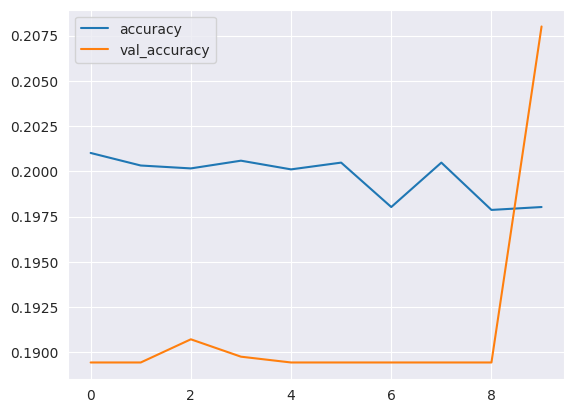

In [55]:
Model_trial[["accuracy","val_accuracy"]].plot()

In [56]:
model_5.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 300, 300, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 300, 300, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                              

In [57]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

125/125 [==============================] - 12s 89ms/step - loss: 1.6095 - accuracy: 0.1888
Train Loss:  1.6094290018081665
Train Accuracy:  0.19934959709644318
--------------------
Validation Loss:  1.6095343828201294
Validation Accuracy:  0.20800000429153442
--------------------
Test Loss:  1.6095120906829834
Test Accuracy:  0.18880000710487366


In [58]:
from tensorflow.keras.models import load_model

In [59]:
tf.saved_model.save(model_5,'/kaggle/working/EfficientNetB1_model.h5')

In [60]:
#!git clone https://github.com/RocketDelivery/efficientnet-serialize.git

In [61]:
#from github.com/RocketDelivery/efficientnet-serialize.git import /efficientnet-serialize


In [62]:
#!pip install ./efficientnet-serialize

In [63]:
"""model_yaml = model_5.to_json()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model_5.save_weights("model.h5")
print("Saved model to disk")"""

'model_yaml = model_5.to_json()\nwith open("model.yaml", "w") as yaml_file:\n    yaml_file.write(model_yaml)\n# serialize weights to HDF5\nmodel_5.save_weights("model.h5")\nprint("Saved model to disk")'